In [1]:
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hampel import hampel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Leitura dos dados

In [2]:
df = pd.read_csv('medidas_04-05-2021/quarterly_measurements_CPD1.csv')

In [3]:
df['total_consumption'] = df['consumption_peak_time'] + df['consumption_off_peak_time'] + df['generated_energy_off_peak_time'] + df['generated_energy_peak_time']

In [4]:
df['collection_date'] = pd.to_datetime(df['collection_date'], format='%Y-%m-%d %H:%M:%S')

In [5]:
df = df.sort_values('collection_date')

In [6]:
df.reset_index(drop=True, inplace=True)

# Remoção de outliers

In [7]:
no_outliers_consumption = hampel(df['total_consumption'], window_size=16, n=2, imputation=True)

In [8]:
df['no_outliers_consumption'] = no_outliers_consumption

# Treinamento do modelo

In [9]:
X = (
    df.collection_date.dt.hour + df.collection_date.dt.minute / 60
).values.reshape((len(df), 1))

In [10]:
y = df.no_outliers_consumption.values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [12]:
start = time.time()
reg = LinearRegression().fit(X_train, y_train)
end = time.time()

In [13]:
print(f"Training time: {end-start} s")

Training time: 0.17876768112182617 s


In [14]:
y_pred = reg.predict(X_test)

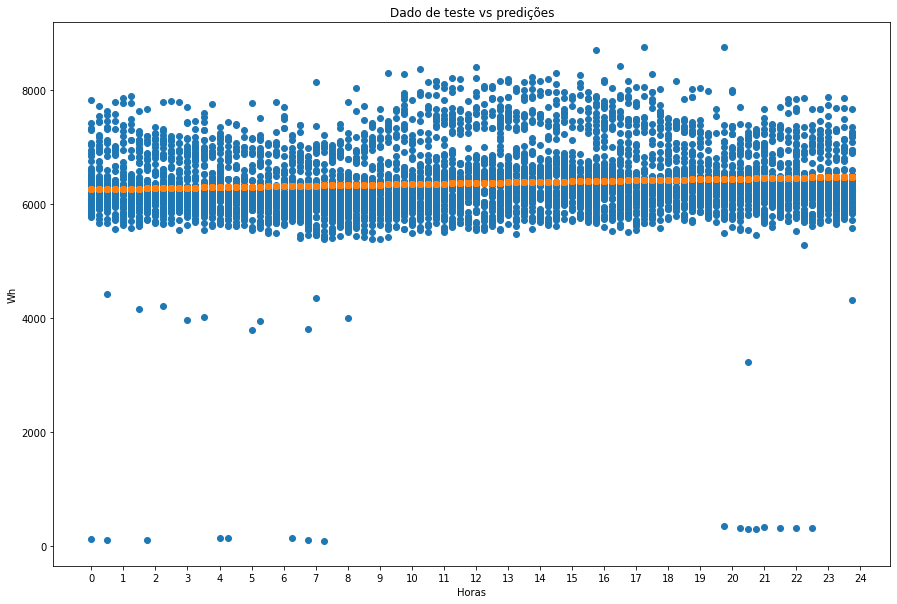

In [15]:
plt.figure(figsize=(15, 10))
plt.title("Dado de teste vs predições")
plt.xlabel("Horas")
plt.ylabel("Wh")
plt.xticks(np.arange(0, 25))
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred);

In [16]:
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

MAE: 399.45274018428034


# Curva de carga

In [17]:
load_curve = reg.predict(np.arange(0, 24, 0.25).reshape(-1, 1))

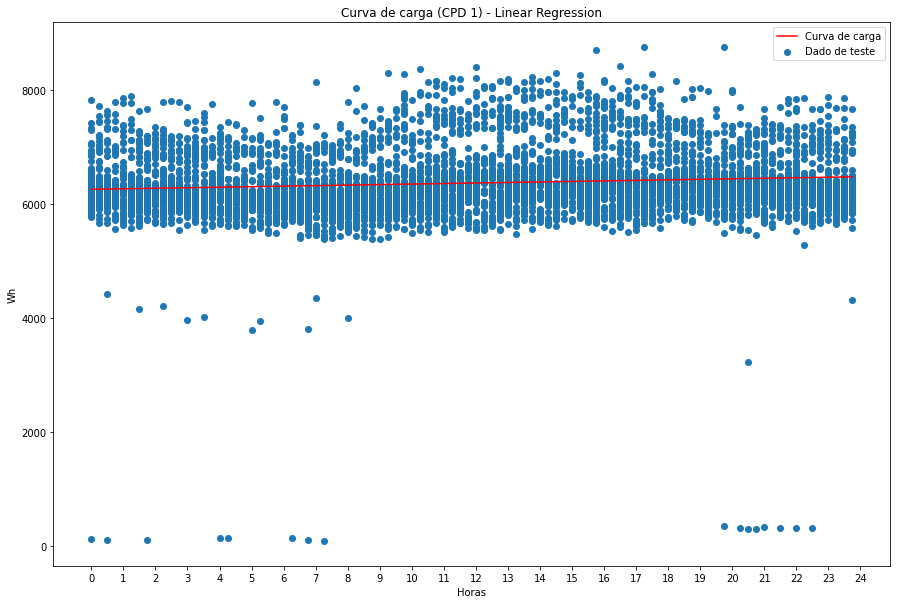

In [18]:
plt.figure(figsize=(15,10))
plt.title("Curva de carga (CPD 1) - Linear Regression")
plt.xlabel("Horas")
plt.ylabel("Wh")
plt.xticks(np.arange(0, 25))
plt.scatter(X_test, y_test, label="Dado de teste")
plt.plot(np.arange(0, 24, 0.25), load_curve, color="red", label="Curva de carga")
plt.legend();

In [19]:
pickle.dump(load_curve, open("linear_regression_load_curve.pk", "wb"))